# Imports

In [1]:
# Global imports
import os 
import cv2
import time
import copy
import random
import pandas as pd
import numpy as np

# Torch imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from tqdm.auto import tqdm, trange
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

torch.cuda.empty_cache()
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset prepration


In [3]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.3045, 0.3578, 0.4824] , std= [0.2182, 0.2242, 0.2571])
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.3049, 0.3587, 0.4833] , std = [0.2188, 0.2247, 0.2572])

])

In [4]:
class MyDataset(Dataset):
    def __init__(self , dataset_path , annotation_path , transform = None):
        self.dataset_path = dataset_path
        self.data_files = os.listdir(dataset_path)
        self.transform = transform
        self.race_to_int = {'White': 0 , 'Black': 1, 'East Asian':2, 'Indian':3 , 'Middle Eastern':4,'Latino_Hispanic':5, 'Southeast Asian':6}
        sorted(self.data_files)
        self.annotations = pd.read_csv(annotation_path)

    def __getitem__(self, idx):
        image_path = self.dataset_path + self.data_files[idx]
        # Read images:
        image = cv2.imread(image_path)
        image = (image/255).astype("float32") # Network needs inputs in range 0-1
        
        # Read label:
        race = self.annotations.loc[self.annotations["file"] == image_path]['race'].values[0]
        int_label = self.race_to_int[race]
        
        # Perform transformation:
        if self.transform == None:
            image = transforms.ToTensor()(image)
        if self.transform:
            image = self.transform(image)
        return image , int_label

    def __len__(self):
        return len(self.data_files)
    
    def show_image(self , race , index):
        self.annotations = self.annotations.sort_values(by=['race' , 'file'])
        race_df = self.annotations[self.annotations['race'] == race]
        annotation = race_df.iloc[index]
        image_path = annotation['file']
        image = cv2.imread(image_path)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        print(annotation)
        
    def show_info(self):
        print("annotations info")
        print(self.annotations.value_counts("race"))

In [5]:
train_dataset_path = "train/"
val_dataset_path = "val/"

image_annotation = {"train/": "fairface_label_train.csv" , 
                    "val/" : "fairface_label_val.csv" , 
                   }

In [6]:
# Just for test
train_dataset = MyDataset(dataset_path = train_dataset_path , annotation_path = image_annotation[train_dataset_path] , transform = train_transforms)
val_dataset = MyDataset(dataset_path = val_dataset_path , annotation_path = image_annotation[val_dataset_path] , transform = val_transforms)


file            train/10010.jpg
age                       20-29
gender                     Male
race                      Black
service_test               True
Name: 10009, dtype: object


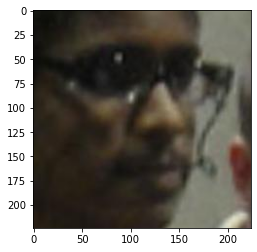

In [7]:
train_dataset.show_image(race = "Black" , index = 1)

In [8]:
train_dataset.show_info()

annotations info
race
White              16527
Latino_Hispanic    13367
Indian             12319
East Asian         12287
Black              12233
Southeast Asian    10795
Middle Eastern      9216
dtype: int64


In [9]:
'''
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std   
    
mean , std = get_mean_std(train_loader)

print(mean , std)
'''

# Main train_loader: mean:   mean = [0.3045, 0.3578, 0.4824] , std= [0.2182, 0.2242, 0.2571]
# Main val_loader: mean:     mean = [0.3049, 0.3587, 0.4833] , std = [0.2188, 0.2247, 0.2572]

'\ndef get_mean_std(loader):\n    # var[X] = E[X**2] - E[X]**2\n    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0\n\n    for data, _ in tqdm(loader):\n        channels_sum += torch.mean(data, dim=[0, 2, 3])\n        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])\n        num_batches += 1\n\n    mean = channels_sum / num_batches\n    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5\n\n    return mean, std   \n    \nmean , std = get_mean_std(train_loader)\n\nprint(mean , std)\n'

In [10]:
'''
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range

BATCH_SIZE = 32 

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
dataloaders_dict = {'train' : train_loader , 'val' : val_loader  }

'''

"\n##########################\n### MNIST DATASET\n##########################\n\n# Note transforms.ToTensor() scales input images\n# to 0-1 range\n\nBATCH_SIZE = 32 \n\ntrain_dataset = datasets.MNIST(root='data', \n                               train=True, \n                               transform=transforms.ToTensor(),\n                               download=True)\n\ntest_dataset = datasets.MNIST(root='data', \n                              train=False, \n                              transform=transforms.ToTensor())\n\n\ntrain_loader = DataLoader(dataset=train_dataset, \n                          batch_size=BATCH_SIZE, \n                          shuffle=True)\n\nval_loader = DataLoader(dataset=test_dataset, \n                         batch_size=BATCH_SIZE, \n                         shuffle=False)\n\n# Checking the dataset\nfor images, labels in train_loader:  \n    print('Image batch dimensions:', images.shape)\n    print('Image label dimensions:', labels.shape)\n    break\ndatal

# Model

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    if feature_extracting == False:
        for param in model.parameters():
            param.requires_grad = True

In [12]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        print(model_name)
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet34":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg11":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    
    elif model_name == "vgg19":
        """ VGG11_bn
        """
        model_ft = models.vgg19(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
        
    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

In [33]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train' , 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            i = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                i += 1
                # forward
                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2

                    else:                
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        outputs = model(inputs)

                        loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                 
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('Phase: {}, Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = "best_Model_"+ str(epoch) + ".pt"
                torch.save(model.state_dict(), PATH)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print('-' * 100)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, val_acc_history

In [34]:
class Add_dropout_To_Resnet(nn.Module):
    def __init__(self , model):
        super(Add_dropout_To_Resnet, self).__init__()
        self.model = model
        self.classifier_layer = nn.Sequential(
            nn.Linear(512 , 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256 , num_classes)
        )
    def forward(self, inputs):
        x = self.model.conv1(inputs)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = x.flatten(start_dim=1)
        x = self.classifier_layer(x)
        return x
    

# You need just change this part

In [35]:
train_dataset_path = "train/"
val_dataset_path = "val/"

image_annotation = {"train/": "fairface_label_train.csv" , 
                    "val/" : "fairface_label_val.csv" , 
                   }

In [36]:
# Name of model
model_name = "resnet34"

# Number of classes in the dataset
num_classes = 7

# Number of epochs to train for
num_epochs = 30

# Batch size
BATCH_SIZE = 32 

# Learning rate of model
LEARNING_RATE = 0.001

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Flag for using pretrain weights
use_pretrained=True

# This flag append a new classifier on top of resnet models(resnet18 and resnet34) 
append_classifier = True

# Initialize the model for this run
init_model = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Send the model to GPU
init_model = init_model.to(device)

In [37]:
if append_classifier:
    model = Add_dropout_To_Resnet(init_model).to(device)
else:
    model = init_model

In [28]:
# Create dataset
train_dataset = MyDataset(dataset_path = train_dataset_path , annotation_path = image_annotation[train_dataset_path] , transform = train_transforms)
val_dataset = MyDataset(dataset_path = val_dataset_path , annotation_path = image_annotation[val_dataset_path] , transform = val_transforms)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE,  shuffle = False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE,  shuffle = False, num_workers=0)

dataloaders_dict = {'train' : train_loader , 'val' : val_loader  }

In [29]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

21,421,902 total parameters.
21,421,902 training parameters.


In [30]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE )
criterion = nn.CrossEntropyLoss()

# Trainig model

In [ ]:
model, val_acc_history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs , is_inception = (model_name=="inception"))

# Load and Test

In [38]:
model.load_state_dict(torch.load("./resnet 32 full my classifier/best_Model_0.pt"))

<All keys matched successfully>

In [39]:
model = model.to(device)

In [40]:
def test(model , loader , criterion):
    model.eval()
    test_loss = 0
    correct = 0
    All_preds = []
    All_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            labels =  labels.to(device)
            preds = model(images)
            loss = criterion(preds , labels)
            test_loss += loss
            preds = torch.argmax(preds , dim = 1)
            All_preds.append(preds.cpu().numpy())
            All_labels.append(labels.cpu().numpy())

            correct += (preds == labels).float().sum()
        print(labels)
        print(preds)
        accuracy = correct / len(loader.dataset)    
        epoch_loss = test_loss / len(loader.dataset)
        print("   loss:%.2f" %epoch_loss.item())
        All_labels = np.concatenate( All_labels, axis=0 )
        All_preds = np.concatenate( All_preds, axis=0 )
    return All_labels ,All_preds

In [41]:
All_labels ,All_preds = test(model , val_loader , criterion)

  0%|          | 0/343 [00:00<?, ?it/s]

C:\Users\Windows\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([3, 0, 3, 3, 0, 1, 4, 1, 5, 5], device='cuda:0')
tensor([0, 0, 3, 3, 0, 1, 0, 1, 4, 5], device='cuda:0')
   loss:0.03


In [42]:
print(confusion_matrix(All_labels ,All_preds ))
print()
print(classification_report(All_labels ,All_preds ))

[[1499   24   74   50  190  217   31]
 [  17 1304    6  100   12   53   64]
 [  49   15 1061    9    9   47  360]
 [  56  124   10 1034   80  143   69]
 [ 281   20   12   73  665  144   14]
 [ 249   94   65  196  174  686  159]
 [  27   48  305   56   16   83  880]]

              precision    recall  f1-score   support

           0       0.69      0.72      0.70      2085
           1       0.80      0.84      0.82      1556
           2       0.69      0.68      0.69      1550
           3       0.68      0.68      0.68      1516
           4       0.58      0.55      0.56      1209
           5       0.50      0.42      0.46      1623
           6       0.56      0.62      0.59      1415

    accuracy                           0.65     10954
   macro avg       0.64      0.65      0.64     10954
weighted avg       0.65      0.65      0.65     10954

